In [1]:
import pandas as pd
import mplfinance as mpf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
from dataclasses import dataclass
import pandas_ta as ta
from qfin_lib import __load_alldata, get_price_channel, row_top, row_bottom, rw_extremes

In [2]:
def trendline_breakout(close: np.array, lookback:int):
    s_tl = np.zeros(len(close))
    s_tl[:] = np.nan

    r_tl = np.zeros(len(close))
    r_tl[:] = np.nan

    sig = np.zeros(len(close))

    for i in (range(lookback, len(close) - 1)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = get_price_channel(window)

        # Find current value of line, projected forward to current bar
        s_val = s_coefs[1] + lookback * s_coefs[0]
        r_val = r_coefs[1] + lookback * r_coefs[0]

        s_tl[i] = s_val
        r_tl[i] = r_val

        if close[i] > r_val:
            sig[i] = 1.0
        elif close[i] < s_val:
            sig[i] = -1.0
        else:
            sig[i] = sig[i - 1]

    return s_tl, r_tl, sig

In [3]:
crypto_data, forex_data = __load_alldata()

for d in crypto_data:
    print(f"Crypto {d.name}: {len(d.data)}")

Loading forex data for 15 minutes:  : 100%|███████| 8/8 [00:00<00:00, 21.60it/s]

Crypto BTC.csv: 55378
Crypto ALGO.csv: 39290
Crypto ETH.csv: 55378
Crypto ADA.csv: 49586
Crypto BNB.csv: 53442
Crypto DOGE.csv: 38966


Profit Factor for BTC.csv 72 1.0350220012606481
Profit Factor for ALGO.csv 72 0.987984394464703
Profit Factor for ETH.csv 72 1.0340761065069772
Profit Factor for ADA.csv 72 1.0131969037401092
Profit Factor for BNB.csv 72 1.0269403983586938
Profit Factor for DOGE.csv 72 1.0218705048466927


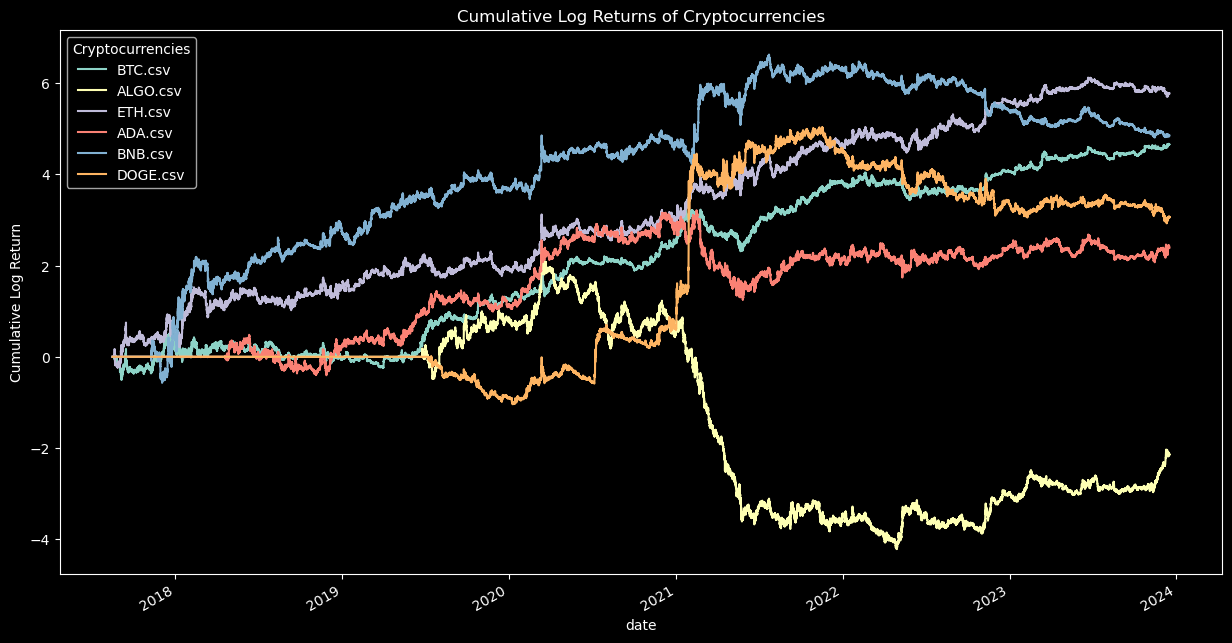

In [4]:
cumulative_returns = pd.DataFrame()

for cr in crypto_data:
    data = cr.data.copy()
    
    lookback = 72
    support, resist, signal = trendline_breakout(data['close'].to_numpy(), lookback)

    data['signal'] = signal

    data['r'] = np.log(data['close']).diff().shift(-1)
    strat_r = data['signal'] * data['r']

    pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
    print(f"Profit Factor for {cr.name}", lookback,  pf)

    cumulative_returns[cr.name] = strat_r.cumsum()

plt.style.use('dark_background')
# Aligning all data on a common date index
cumulative_returns = cumulative_returns.fillna(method='ffill').fillna(0)

# Plotting
plt.style.use('dark_background')
cumulative_returns.plot(figsize=(15, 8))
plt.ylabel("Cumulative Log Return")
plt.title("Cumulative Log Returns of Cryptocurrencies")
plt.legend(title="Cryptocurrencies")
plt.show()


In [5]:
crypto_data[1].data.tail(1)

,open,high,low,close,volume
date,,,,,
2023-12-16 23:00:00,0.1989,0.199,0.1974,0.1982,1415938.0


In [6]:
# lookbacks = list(range(24, 169, 2))
# pfs = []

# # Assuming crypto_data and trendline_breakout function are defined earlier
# for lookback in tqdm(lookbacks, 'Processing lookbacks: '):
#     for cr in crypto_data:
#         data = cr.data.copy()

#         support, resist, signal = trendline_breakout(data['close'].to_numpy(), lookback)
#         data['signal'] = signal
#         data['r'] = np.log(data['close']).diff().shift(-1)
#         strat_r = data['signal'] * data['r']

#         pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
#         pfs.append(pf)

#     # Printing or storing the average profit factor for each lookback
#     avg_pf = np.mean(pfs)
#     print(f"Average Profit Factor for lookback {lookback}: {avg_pf}")

# # Plotting
# plt.figure(figsize=(15, 8))
# plt.plot(lookbacks, pfs, marker='o')
# plt.axhline(y=1.0, color='r', linestyle='--')
# plt.xlabel("Lookback Period")
# plt.ylabel("Profit Factor")
# plt.title("Profit Factor vs Lookback Period")
# plt.show()


# SEE MULTIPROCESSING SCRIPT

In [7]:
import json
# Load the data from the JSON file
with open('crypto_profit_factors.json', 'r') as f:
    crypto_profit_factors = json.load(f)

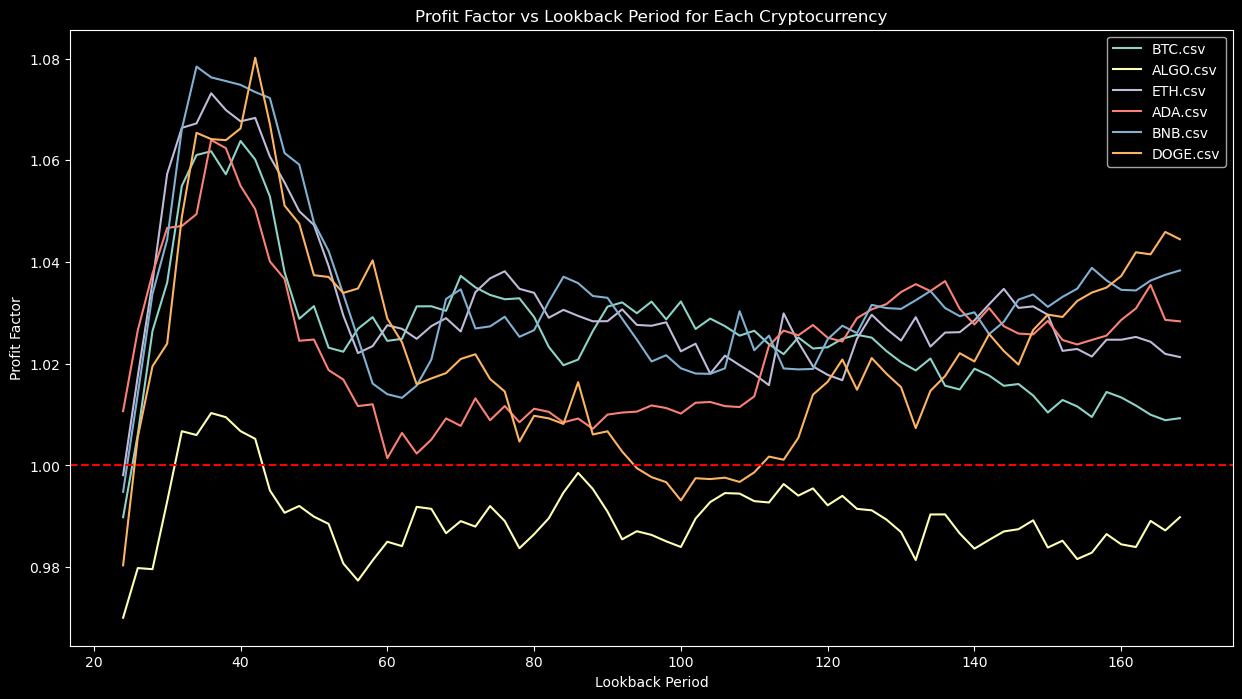

In [10]:
lookbacks = list(range(24, 169, 2))

# Plotting
plt.figure(figsize=(15, 8))
for crypto_name, pfs in crypto_profit_factors.items():
    plt.plot(lookbacks, pfs, label=crypto_name)

plt.axhline(y=1.0, color='r', linestyle='--')
plt.xlabel("Lookback Period")
plt.ylabel("Profit Factor")
plt.title("Profit Factor vs Lookback Period for Each Cryptocurrency")
plt.legend()
plt.show()